In [16]:
import os
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data as web
import seaborn as sn

In [17]:
key =        "747763d6e3b19b642632f6d812562c5ea539cd8c"
start =      dt.datetime(2008,1,1)
end =        dt.datetime(2020,1,1)
df =         web.DataReader('AAPL',"tiingo",start,end, api_key=key)
train =      web.DataReader('AAPL',"tiingo",start,end, api_key=key)

In [18]:
df.shape
df.columns

Index(['close', 'high', 'low', 'open', 'volume', 'adjClose', 'adjHigh',
       'adjLow', 'adjOpen', 'adjVolume', 'divCash', 'splitFactor'],
      dtype='object')

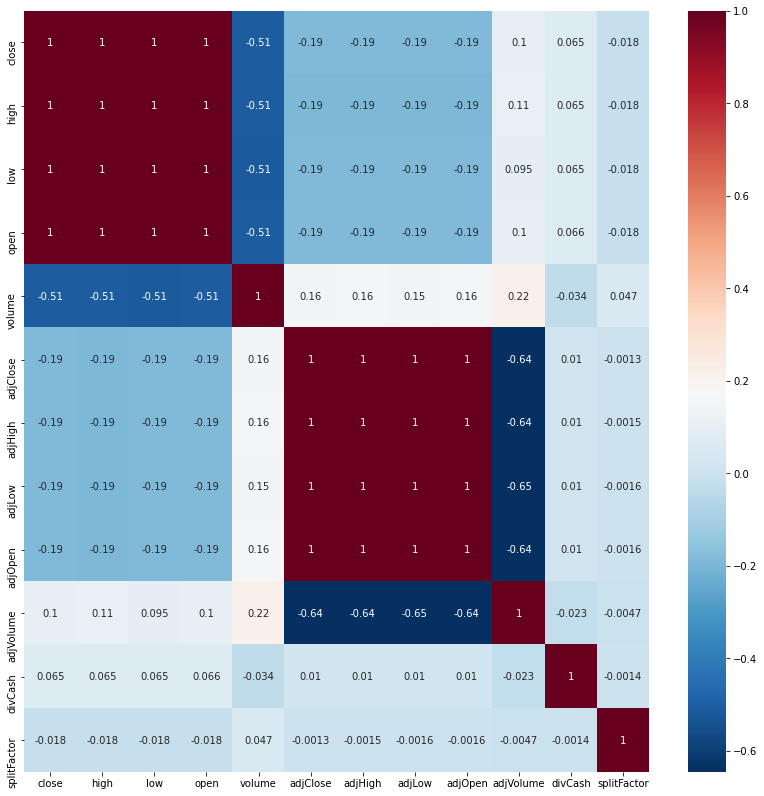

In [92]:
#df.head()
#df.isnull().sum()
#df.describe().transpose()
plt.figure(figsize=(14,14))
sn.heatmap(df.corr(),annot=True, cmap='RdBu_r');

In [20]:
dataset = df[['low']]
dataset

low
symbol date                             
AAPL   2008-01-02 00:00:00+00:00  192.55
       2008-01-03 00:00:00+00:00  192.69
       2008-01-04 00:00:00+00:00  178.89
       2008-01-07 00:00:00+00:00  170.23
       2008-01-08 00:00:00+00:00  170.80
...                                  ...
       2019-12-24 00:00:00+00:00  282.92
       2019-12-26 00:00:00+00:00  284.70
       2019-12-27 00:00:00+00:00  288.12
       2019-12-30 00:00:00+00:00  285.22
       2019-12-31 00:00:00+00:00  289.52

[3021 rows x 1 columns]

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(dataset)

X = []
y = []
steps = 60

for i in range(steps,dataset.shape[0]):
  X.append(training_set_scaled[i-steps:i,0])
  y.append(training_set_scaled[i,0])

X_train = np.array(X)
y_train = np.array(y)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [22]:
X_train,X_test,y_train,y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print(f'X_train {X_train.shape} \ny_train {y_train.shape} \nX_test {X_test.shape} \ny_test {y_test.shape}')

X_train (2368, 60, 1) 
y_train (2368,) 
X_test (593, 60, 1) 
y_test (593,)


In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import metrics 

In [84]:
history =                 {}
scores =                  []
error_rate =              []
mean_error =              0

# Number of hidden units inside of hidden cells in hidden layer 
# Can affect the dimensionality of the units computed and run time (Dont go crazy here)
n = 100
regressor = Sequential()

# Return sequences for the first two layers to return time step info
regressor.add(LSTM(units=n, return_sequences=True, input_shape = (X_train.shape[1],1)))
regressor.add(LSTM(units=n, return_sequences=True))
regressor.add(LSTM(units=n))

# Single dense layer to transform our 50 dimension output from the last step dim n -> 1
regressor.add(Dense(units=1))

# One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE
history = regressor.compile(optimizer='adam',loss='mean_squared_error', metrics=['mse'])
regressor.fit(X_train,y_train,epochs=100, batch_size=37, verbose=True);

pred = regressor.predict(X_test)
error_rate.append((y_test - pred))
total_error = np.mean(error_rate)
scores = regressor.evaluate(X_train, y_train, verbose=0, steps=60)

## MSE account for variance and bias 
## RMSE accounts for the variance from error --> error or the residual
print('-------------------------------------------------------------------------------------------')
print(f'> Mean Square Error (MSE): {regressor.metrics_names[1]} of {scores[1]} (+- {np.std(scores[1])})')
print(f'> Standard Error (RSME): {scores[0]**0.5}')
print('-------------------------------------------------------------------------------------------')

Epoch 1/100
64/64 [==============================] - 1s 12ms/step - loss: 0.0099 - mse: 0.0099
Epoch 2/100
64/64 [==============================] - 1s 10ms/step - loss: 0.0024 - mse: 0.0024
Epoch 3/100
64/64 [==============================] - 1s 11ms/step - loss: 0.0026 - mse: 0.0026
Epoch 4/100
64/64 [==============================] - 1s 10ms/step - loss: 0.0022 - mse: 0.0022
Epoch 5/100
64/64 [==============================] - 1s 10ms/step - loss: 0.0017 - mse: 0.0017
Epoch 6/100
64/64 [==============================] - 1s 9ms/step - loss: 0.0019 - mse: 0.0019
Epoch 7/100
64/64 [==============================] - 1s 9ms/step - loss: 0.0017 - mse: 0.0017
Epoch 8/100
64/64 [==============================] - 1s 9ms/step - loss: 0.0015 - mse: 0.0015
Epoch 9/100
64/64 [==============================] - 1s 9ms/step - loss: 0.0012 - mse: 0.0012
Epoch 10/100
64/64 [==============================] - 1s 9ms/step - loss: 9.9265e-04 - mse: 9.9265e-04
Epoch 11/100
64/64 [==========================

In [85]:
regressor.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
lstm_33 (LSTM)               (None, 60, 100)           80400     
_________________________________________________________________
lstm_34 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Change end date and Ticker for more stock predictions 
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime(2020,4,30)
df_test = web.DataReader('AAPL','tiingo',test_start, api_key=key)
actual_stock_price = df_test.iloc[:, 1:2].values
target = df_test['open']

df_test.shape

(243, 12)

In [87]:
data_set_total = pd.concat((train['open'], df_test['open']), axis = 0)
inputs = data_set_total[len(data_set_total) - len(df_test) - steps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

steps = 60 
end_range = steps + len(actual_stock_price)

for i in range(steps, end_range):
  X_test.append(inputs[i-steps:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

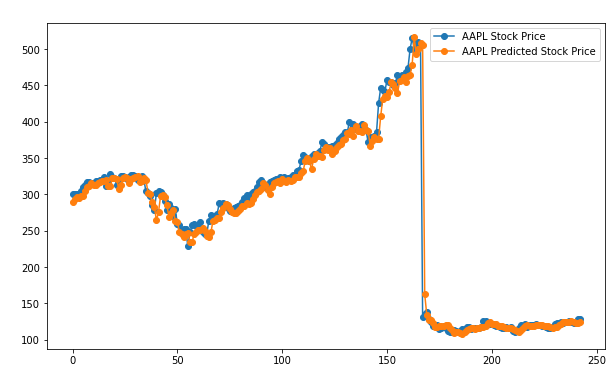

In [88]:
plt.figure(figsize=(10,6))
plt.plot(actual_stock_price, label = 'AAPL Stock Price',marker='o')
plt.plot(predicted_stock_price,label = 'AAPL Predicted Stock Price', marker='o')
plt.title('3 Month Stock Price Prediction',color="white")
plt.xlabel('Time', color="white")
plt.ylabel('AAPL Stock Price', color="white")
plt.legend()
plt.show()

In [83]:
error_rate = []
for i in range(1, len(actual_stock_price)):
  if predicted_stock_price[i] != actual_stock_price[i]:
    error_rate.append( ( actual_stock_price[i] - predicted_stock_price[i])/2)
    
mse = np.mean(error_rate)
print(f' Mean Square Error {scores[1]*100}')
print(f'Root Mean Errror {(scores[1]*100)**0.5}')

 Mean Square Error 0.06436652038246393
Root Mean Errror 0.25370557814613365


In [90]:
error_ = []
for i in range(1, len(actual_stock_price)):
  error_.append( ( actual_stock_price[i] - predicted_stock_price[i]))

sum(error_)/len(error_)

array([2.92055329])